# Category prediction using comments

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,30)
plt.rcParams.update({'font.size': 22})
import pandas as pd
import tensorflow as tf
import nltk

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import time
import pickle
import collections
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
from random import seed
RANDOM = 42
seed(RANDOM)
np.random.seed(RANDOM)

In [3]:
videos_df = pd.read_csv("videos.csv")
comments_df = pd.read_csv("comments.csv")

In [4]:
le = preprocessing.LabelEncoder()
le.fit(videos_df['category_id'])
videos_df['category_id'] = le.transform(videos_df['category_id']) 

In [5]:
video_id_to_category = {}
category_id_to_word = {}

for _, row in videos_df.iterrows():
    if row['video_id'] not in video_id_to_category:
        video_id_to_category[row['video_id']] = row['category_id']
    if row['category_id'] not in category_id_to_word:
        category_id_to_word[row['category_id']] = row['category_name']
    

In [6]:
comments_df['category_id'] = comments_df.apply(lambda row: video_id_to_category[row['video_id']], axis=1)

In [7]:
comments_df.groupby(['category_id']).agg(['count'])

,video_id,comment_text,likes,replies
,count,count,count,count
category_id,,,,
0,65102,65096,65102,65102
1,13010,13010,13010,13010
2,234495,234483,234495,234495
3,16811,16809,16811,16811
4,83322,83318,83322,83322
5,7737,7737,7737,7737
6,29079,29079,29079,29079
7,178734,178720,178734,178734


In [8]:
comments_df = comments_df[comments_df['category_id'] != 14]
comments_df = comments_df[comments_df['category_id'] != 15]

In [9]:
comments_df = comments_df.dropna()

In [10]:
comments_df.isnull().sum()

video_id        0
comment_text    0
likes           0
replies         0
category_id     0
dtype: int64

In [11]:
concat = comments_df.groupby('video_id')['comment_text'].apply(list)
concat.head()

video_id
--JinobXWPk    [I saw this wandering spider in our bathroom s...
--y69Ui8xwM    [*What was your favourite of these 10 amazing ...
-1fzGnFwz9M    [I make interesting cartoons and I need your h...
-2hRYEFiPSA    [One thing that's upset me the most about Ches...
-3AGlBYyLjo    [Where are the other interviews Gary Chandling...
Name: comment_text, dtype: object

In [12]:
concat_df = concat.reset_index()
concat_df.head()

,video_id,comment_text
0,--JinobXWPk,[I saw this wandering spider in our bathroom s...
1,--y69Ui8xwM,[*What was your favourite of these 10 amazing ...
2,-1fzGnFwz9M,[I make interesting cartoons and I need your h...
3,-2hRYEFiPSA,[One thing that's upset me the most about Ches...
4,-3AGlBYyLjo,[Where are the other interviews Gary Chandling...


In [14]:
concat_df['category_id'] = concat_df.apply(lambda row: video_id_to_category[row['video_id']], axis=1)

In [15]:
concat_df['comment_text'] = concat_df.apply(lambda row: " ".join(row['comment_text']), axis=1)

In [16]:
def clean_text(row, to_stem):
    # tokenize
    text = row['comment_text']
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [token for token in tokens if token.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # stemming words
    if to_stem:
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    return " ".join(words)

In [17]:
to_stem = False
concat_df['comment_text'] = concat_df.apply(lambda row: clean_text(row, to_stem), axis=1)

In [18]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(concat_df['comment_text'].values)
X = counts
y = concat_df['category_id'].to_numpy()

In [31]:
concat_df.to_csv("concat_comment_videos_df.csv", index=False)

In [19]:
def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]
X, y = unison_shuffled_copies(X, y)
X = np.nan_to_num(X)

#### See baseline of some models to see if task is doable

In [20]:
classifiers = {"LogisticRegression": LogisticRegression(),
               "MultinomialNB": MultinomialNB(),
               "RandomForestClassifier": RandomForestClassifier(),
               "SVC": SVC(probability=True),
               "KNeighborsClassifier": KNeighborsClassifier(),
               "DecisionTreeClassifier": DecisionTreeClassifier()}

In [21]:
accuracies = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM)
for classifier, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[classifier] = accuracy_score(y_test, y_pred)

In [22]:
accuracies

{'LogisticRegression': 0.5993640699523053,
 'MultinomialNB': 0.356120826709062,
 'RandomForestClassifier': 0.3863275039745628,
 'SVC': 0.21144674085850557,
 'KNeighborsClassifier': 0.5246422893481717,
 'DecisionTreeClassifier': 0.3688394276629571}

#### Tuning KNN
Best: 0.590461 using {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}

In [27]:
# Params
algorithm = ['auto']
n_neighbors = range(17, 25)#11-2
weights = ['distance', 'uniform']

param_grid = dict(algorithm=algorithm, n_neighbors=n_neighbors, weights=weights)

model = KNeighborsClassifier()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s


Best: 0.590461 using {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}
Execution time: 27.72848868370056 ms


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.6s finished


#### Tuning Random Forest
Best: 0.495707 using {'n_estimators': 88, 'random_state': 42}

In [29]:
# Params
n_estimators = range(81, 101)
random_state = [RANDOM]

param_grid = dict(n_estimators=n_estimators, random_state=random_state)

model = RandomForestClassifier()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


Best: 0.495707 using {'n_estimators': 88, 'random_state': 42}
Execution time: 477.69982385635376 ms


#### Tuning Logistic Regression
Best: 0.658824 using {'C': 35, 'penalty': 'l2', 'random_state': 42}

In [34]:
# Params
penalty = ['l2']
C = [31, 32, 33, 34, 35, 36, 37, 38, 39]
random_state = [RANDOM]

param_grid = dict(penalty=penalty, C=C, random_state=random_state)

model = LogisticRegression()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.2min finished


Best: 0.658824 using {'C': 35, 'penalty': 'l2', 'random_state': 42}
Execution time: 136.19749450683594 ms


#### Tuning SVM
Best: 0.645151 using {'C': 21, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 42}

In [38]:
# Params
C = range(16,25)
gamma = [0.1]
kernel = ['rbf']
random_state = [RANDOM]
param_grid = dict(C=C, gamma=gamma, kernel=kernel, random_state=random_state)

model = SVC()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.2min finished


Best: 0.645151 using {'C': 21, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 42}
Execution time: 806.9251224994659 ms


#### Tuning Naive Bayes
Best: 0.554849 using {'alpha': 0.0, 'fit_prior': False}

In [40]:
# Params
alpha = np.linspace(0.0, 10, num=21)
fit_prior = [True, False]
param_grid = dict(alpha=alpha, fit_prior=fit_prior)

model = MultinomialNB()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.8s


Best: 0.554849 using {'alpha': 0.0, 'fit_prior': False}
Execution time: 12.429587125778198 ms


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   12.2s finished


#### Plot confusion matrix for best model

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM, stratify=y)
classifier = LogisticRegression(C=35, penalty='l2', random_state=RANDOM)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

Normalized confusion matrix


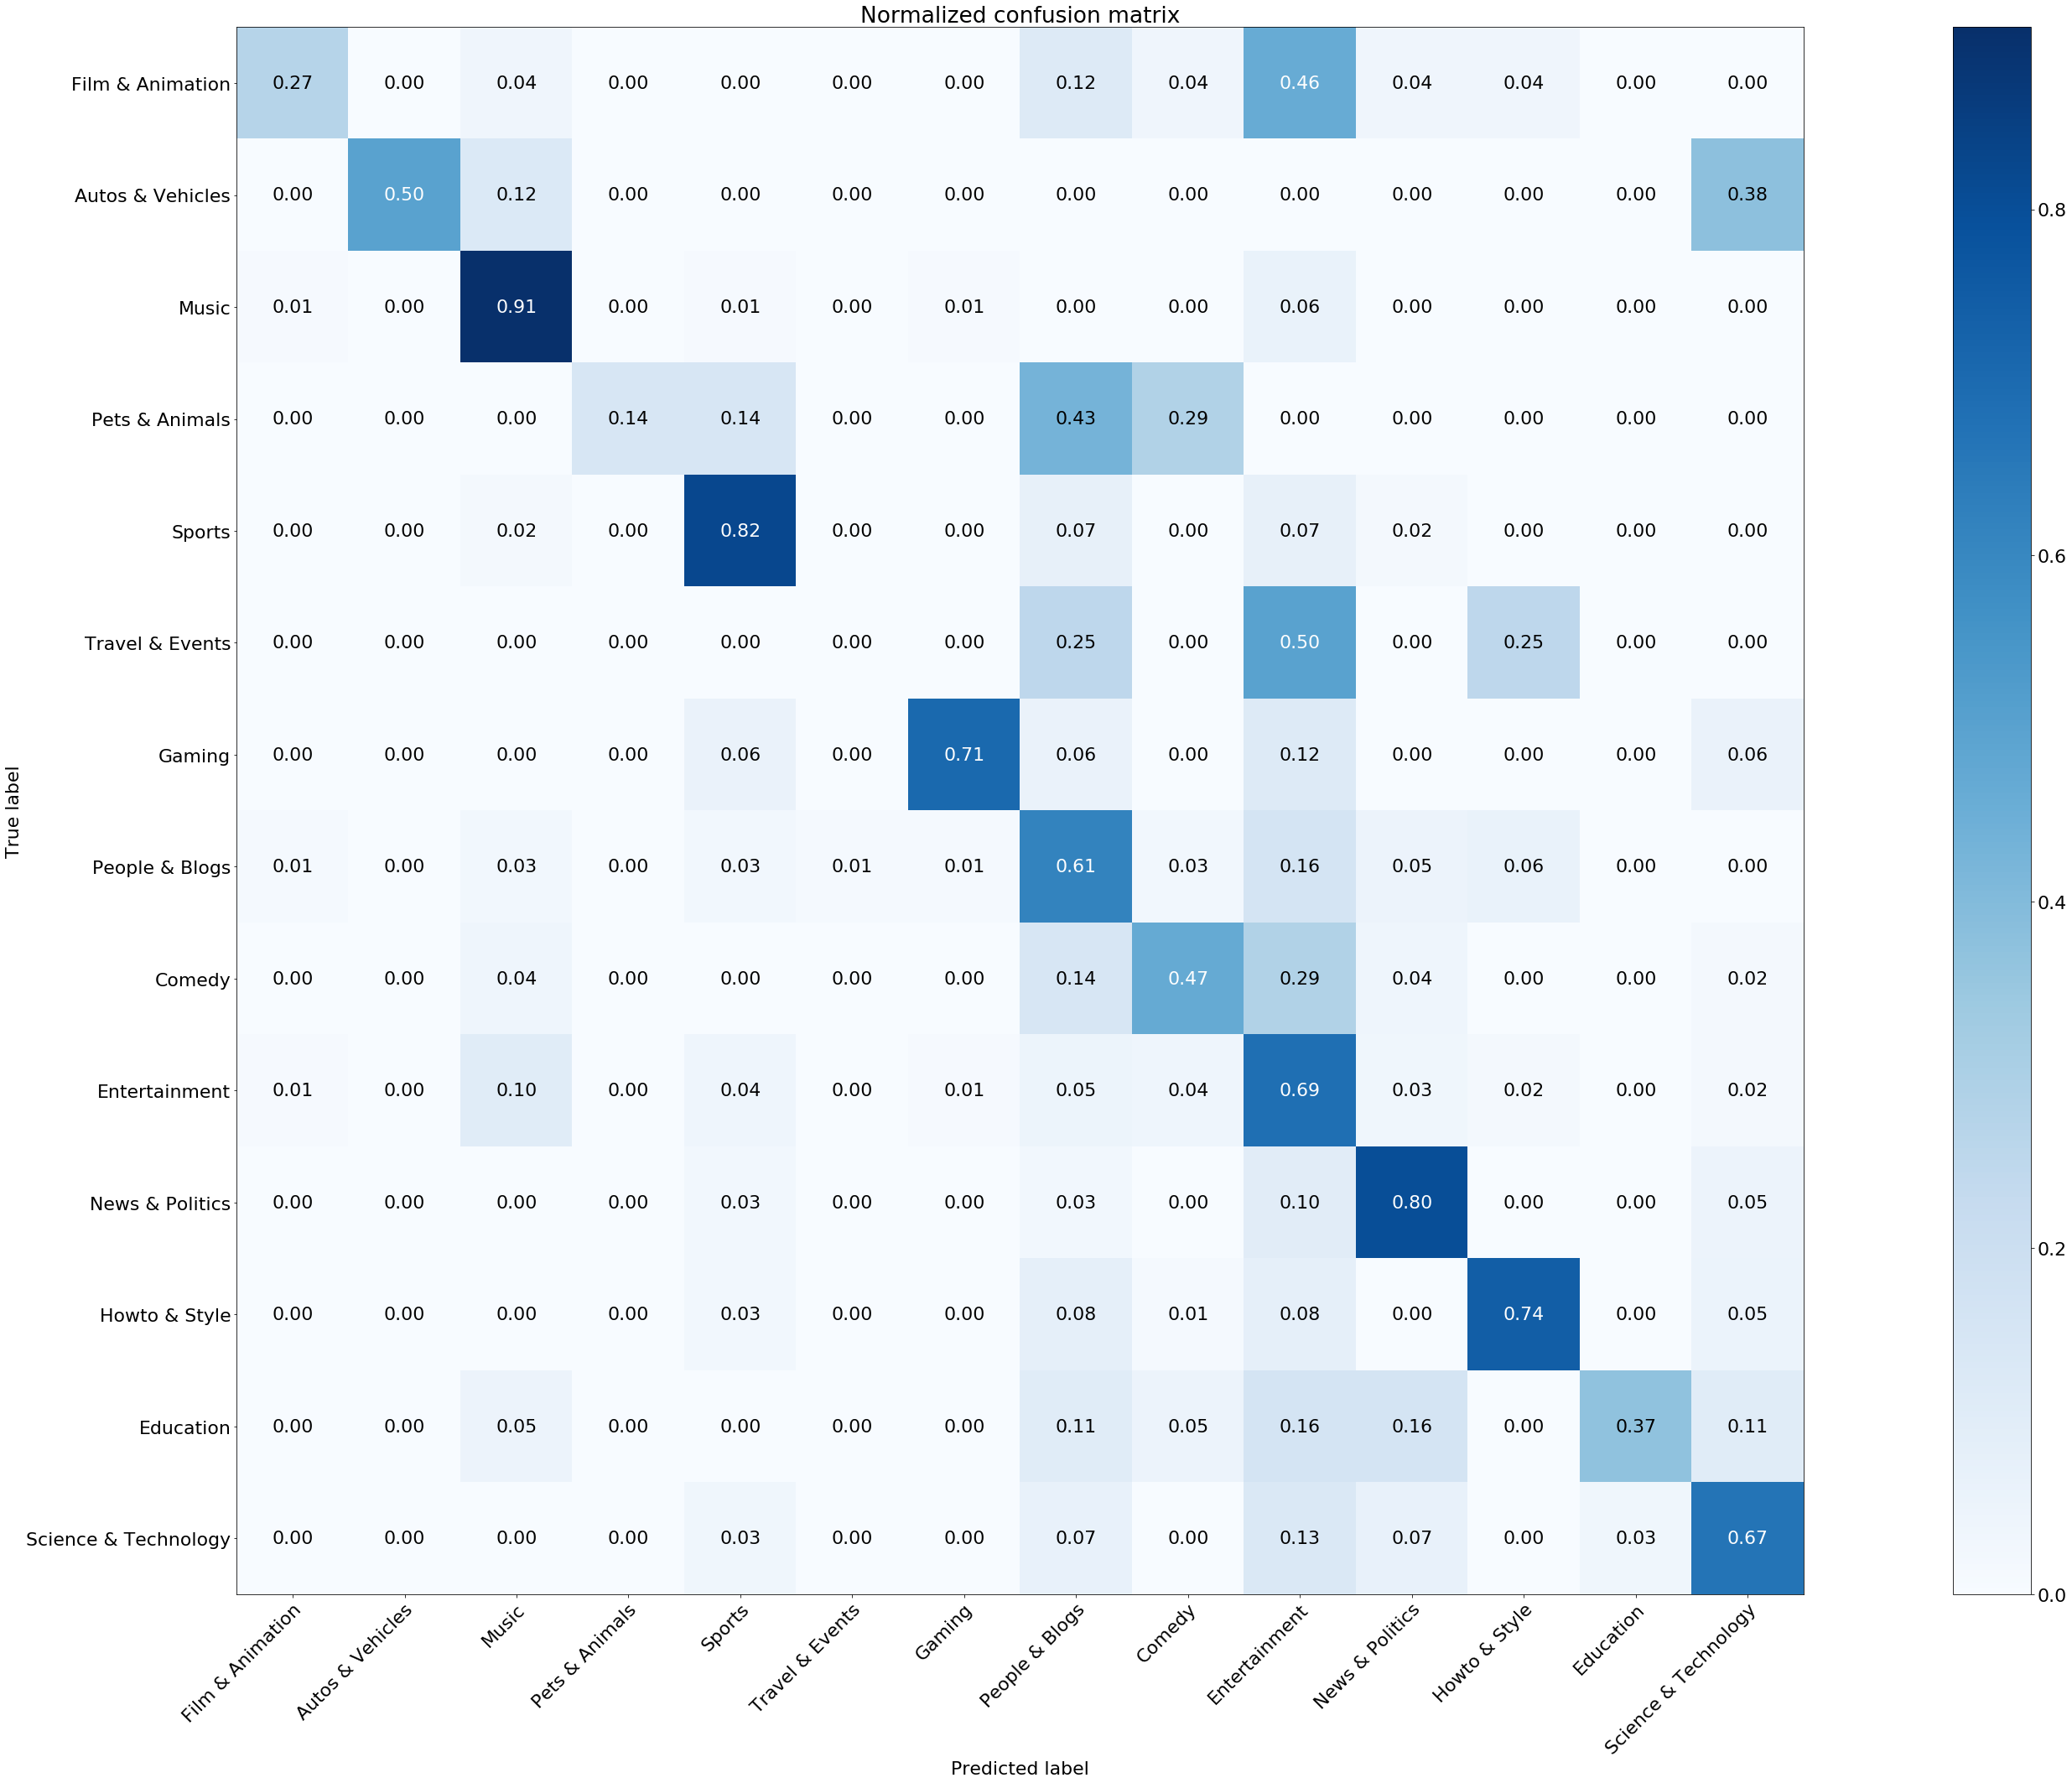

In [25]:
np.set_printoptions(precision=2)
# -2 to remove the categories with too little samples
class_names = np.array([i[1] for i in sorted(list(category_id_to_word.items()), key=lambda x: x[0])][:-2])

# Plot non-normalized confusion matrix

# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()